In [ ]:
import json
import pandas as pd 
import numpy as np 
from glob import glob
import os
import matplotlib.pyplot as plt
import shutil
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle
from PIL import Image
from tqdm.auto import tqdm
import roifile
import cv2
import random
import imgaug.augmenters as iaa

In [ ]:
folder_path=glob("../../data/ddh_standard_frame_data/*")

def createDirectory(directory):
    """_summary_
        create Directory
    Args:
        directory (string): file_path
    """    
    try:
        if not os.path.exists(directory):
            os.makedirs(directory)
    except OSError:
        print("Error: Failed to create the directory.")
        
def expand2square(pil_img, background_color):
    """_summary_
        pillow image make Image to be padded
    Args:
        pil_img (Pillow image): Image to be padded
        background_color (_type_): 

    Returns:
        _type_: _description_
    """    
    width, height = pil_img.size
    if width == height:
        return pil_img
    elif width > height:
        result = Image.new(pil_img.mode, (width, width), background_color)
        result.paste(pil_img, (0, (width - height) // 2))
        return result
    else:
        result = Image.new(pil_img.mode, (height, height), background_color)
        result.paste(pil_img, ((height - width) // 2, 0))
        return result



In [ ]:
# .zip zipper and .Roi file open & save
for i in range(1,21):
    file_list=glob('../../data/pre_DDH/'+str(i)+'/seg_label/*.zip')
    output_dir = "../../data/pre_DDH/"+str(i)+"/segLabel/"
    format = "zip"
    for j in range(len(file_list)):
        createDirectory(output_dir+os.path.splitext(os.path.basename(file_list[j]))[0][:os.path.splitext(os.path.basename(file_list[j]))[0].find('_')])
        shutil.unpack_archive(file_list[j], output_dir+os.path.splitext(os.path.basename(file_list[j]))[0][:os.path.splitext(os.path.basename(file_list[j]))[0].find('_')], format)
        

In [ ]:
# polygon to mask
roi_list=glob('../../data/pre_DDH/**/segLabel/**')
image_list=[f.replace('/segLabel', '/Standard')+'.bmp' for f in roi_list]
mask_list=[f.replace('/segLabel', '/raw_seg_mask') for f in roi_list]
for i in tqdm(range(len(image_list))):
    createDirectory(mask_list[i])
    for j in range(1,4):
        try:
            roi = roifile.ImagejRoi.fromfile(roi_list[i]+'/'+str(j)+'.roi')
        except:
            try:
                roi = roifile.ImagejRoi.fromfile(roi_list[i]+'/'+str(j)+'-1.roi')
            except:
                break;
        
        image=Image.open(image_list[i])
        polygon=roi.integer_coordinates
        polygon[:,0]+=roi.left
        polygon[:,1]+=roi.top
        mask= np.zeros((image.height,image.width))
        mask=cv2.fillPoly(mask,[polygon],255)
        cv2.imwrite(mask_list[i]+'/'+str(j)+'.png',mask)


In [ ]:
#classification dataset create
standard_image_list=glob('../../data/pre_DDH/**/Standard/*.bmp')
not_standard_image_list=glob('../../data/pre_DDH/**/Not_Standard/*.bmp')
padding_standard_image_list=[f.replace('/pre_DDH', '/classificationDDH/dataset') for f in standard_image_list]
padding_standard_image_list=[f.replace('.bmp', '.png') for f in padding_standard_image_list]
padding_standard_image_list=[f.replace('/Standard', '') for f in padding_standard_image_list]
padding_not_standard_image_list=[f.replace('/pre_DDH', '/classificationDDH/dataset') for f in not_standard_image_list]
padding_not_standard_image_list=[f.replace('.bmp', '.png') for f in padding_not_standard_image_list]
padding_not_standard_image_list=[f.replace('/Not_Standard', '') for f in padding_not_standard_image_list]
image_size=512
case_list=[]
file_list=[]
class_list=[]
for i in tqdm(range(len(standard_image_list))):
    case=os.path.basename(os.path.dirname(os.path.dirname(standard_image_list[i])))
    file_name=os.path.basename(padding_standard_image_list[i])
    createDirectory(os.path.dirname(padding_standard_image_list[i]))
    image=expand2square(Image.open(standard_image_list[i]),(0,0,0))
    image=image.resize((image_size,image_size))
    image.save(padding_standard_image_list[i])
    case_list.append(case)
    file_list.append(file_name)
    class_list.append(1)
    
for i in tqdm(range(len(not_standard_image_list))):
    case=os.path.basename(os.path.dirname(os.path.dirname(not_standard_image_list[i])))
    file_name=os.path.basename(padding_not_standard_image_list[i])
    createDirectory(os.path.dirname(padding_not_standard_image_list[i]))
    image=expand2square(Image.open(not_standard_image_list[i]),(0,0,0))
    image=image.resize((image_size,image_size))
    image.save(padding_not_standard_image_list[i])
    case_list.append(case)
    file_list.append(file_name)
    class_list.append(0)
classification_dataset=pd.DataFrame({'case':case_list,'file name':file_list,'standard class':class_list})
classification_dataset.to_csv('../../data/classificationDDH/classification_dataset.csv',index=False)

In [425]:
#classification augmentation dataset create
df_dataset=pd.read_csv('../../data/classificationDDH/classification_dataset.csv')
file_path='../../data/classificationDDH/dataset/'
aug_file_path='../../data/classificationDDH/aug_dataset/'
train_case_list=[]
train_file_list=[]
train_class_list=[]
test_case_list=[]
test_file_list=[]
test_class_list=[]
val_case_list=[]
val_file_list=[]
val_class_list=[]
def classification_image_aug(image):
    src_image=np.array(image)
    images=[src_image]*6
    images[1]=iaa.fliplr(images[1])
    images[2]=iaa.flipud(images[2])
    images[3]=iaa.fliplr(images[3])
    images[3]=iaa.flipud(images[3])
    r=random.randrange(1,360)
    images[4]=iaa.Rotate((r))(image=images[4]) 
    r=random.randrange(1,360)
    images[5]=iaa.Rotate((r))(image=images[5]) 
    return images  
for i in tqdm(range(len(df_dataset))):
    case=df_dataset.loc[i]['case']
    file_name=df_dataset.loc[i]['file name']
    label=df_dataset.loc[i]['standard class']
    file_raw_name=os.path.splitext(file_name)[0]
    if case==1 or case==20:
        set_name='test'
        image=Image.open(file_path+str(case)+'/'+file_name)
        createDirectory(aug_file_path+set_name+'/'+str(case))
        test_case_list.append(case)
        test_class_list.append(label)
        test_file_list.append(file_raw_name+'.png')
        image.save(aug_file_path+set_name+'/'+str(case)+'/'+file_raw_name+'.png')
    elif case==2 or case==3:
        set_name='val'
        image=Image.open(file_path+str(case)+'/'+file_name)
        createDirectory(aug_file_path+set_name+'/'+str(case))
        val_case_list.append(case)
        val_class_list.append(label)
        val_file_list.append(file_raw_name+'.png')
        image.save(aug_file_path+set_name+'/'+str(case)+'/'+file_raw_name+'.png')
    else:
        set_name='train'
        image=Image.open(file_path+str(case)+'/'+file_name)
        augmented_images = classification_image_aug(image)
        createDirectory(aug_file_path+set_name+'/'+str(case))
        for k in range(6):
            train_case_list.append(case)
            train_class_list.append(label)
            train_file_list.append(file_raw_name+'_'+str(k)+'.png')
            Image.fromarray(augmented_images[k]).save(aug_file_path+set_name+'/'+str(case)+'/'+file_raw_name+'_'+str(k)+'.png')
        
train_aug_classification_dataset=pd.DataFrame({'case':train_case_list,'file name':train_file_list,'standard class':train_class_list})
train_aug_classification_dataset.to_csv('../../data/classificationDDH/train_aug_classification_dataset.csv',index=False)
test_aug_classification_dataset=pd.DataFrame({'case':test_case_list,'file name':test_file_list,'standard class':test_class_list})
test_aug_classification_dataset.to_csv('../../data/classificationDDH/test_aug_classification_dataset.csv',index=False)
val_aug_classification_dataset=pd.DataFrame({'case':val_case_list,'file name':val_file_list,'standard class':val_class_list})
val_aug_classification_dataset.to_csv('../../data/classificationDDH/val_aug_classification_dataset.csv',index=False)

  0%|          | 0/39349 [00:00<?, ?it/s]

In [ ]:
#segmentation dataset create
image_list=glob('../../data/pre_DDH/**/Standard/*.bmp')
mask_list=[f.replace('.bmp', '') for f in image_list]
mask_list=[f.replace('/Standard', '/raw_seg_mask') for f in mask_list]
padding_image_list=[f.replace('/pre_DDH', '/segmentationDDH/dataset') for f in image_list]
padding_image_list=[f.replace('.bmp', '.png') for f in padding_image_list]
padding_image_list=[f.replace('/Standard', '/image') for f in padding_image_list]

padding_mask_list=[f.replace('/pre_DDH', '/segmentationDDH/dataset') for f in mask_list]
padding_mask_list=[f.replace('/raw_seg_mask', '/mask') for f in padding_mask_list]

image_size=512
case_list=[]
file_list=[]
class_list=[]
for i in tqdm(range(len(image_list))):
    case=os.path.basename(os.path.dirname(os.path.dirname(image_list[i])))
    file_name=os.path.basename(padding_image_list[i])
    createDirectory(os.path.dirname(padding_image_list[i]))
    createDirectory(padding_mask_list[i])
    image=expand2square(Image.open(image_list[i]),(0,0,0))
    image=image.resize((image_size,image_size))
    image.save(padding_image_list[i])
    case_list.append(case)
    file_list.append(file_name)
    class_list.append(os.path.splitext(file_name)[0])
    for j in range(1,4):
        
        mask=expand2square(Image.open(mask_list[i]+'/'+str(j)+'.png'),(0))
        mask=mask.resize((image_size,image_size))
        mask.save(padding_mask_list[i]+'/'+str(j)+'.png')
segmentation_dataset=pd.DataFrame({'case':case_list,'file name':file_list,'standard mask':class_list})
segmentation_dataset.to_csv('../../data/segmentationDDH/segmentation_dataset.csv',index=False)    

In [424]:
#segmentation augmentation dataset create
df_dataset=pd.read_csv('../../data/segmentationDDH/segmentation_dataset.csv')
file_path='../../data/segmentationDDH/dataset/'
aug_file_path='../../data/segmentationDDH/aug_dataset/'
train_case_list=[]
train_file_list=[]
train_class_list=[]
test_case_list=[]
test_file_list=[]
test_class_list=[]
val_case_list=[]
val_file_list=[]
val_class_list=[]
def segmentation_image_aug(image,mask1,mask2):
    src_image=np.array(image)
    src_mask1=np.array(mask1)
    src_mask2=np.array(mask2)
    images=[src_image]*6
    masks=[src_mask1]*6
    masks1=[src_mask2]*6
    masks[1]=iaa.fliplr(masks[1])
    masks[2]=iaa.flipud(masks[2])
    masks[3]=iaa.fliplr(masks[3])
    masks[3]=iaa.flipud(masks[3])
    images[1]=iaa.fliplr(images[1])
    images[2]=iaa.flipud(images[2])
    images[3]=iaa.fliplr(images[3])
    images[3]=iaa.flipud(images[3])
    masks1[1]=iaa.fliplr(masks1[1])
    masks1[2]=iaa.flipud(masks1[2])
    masks1[3]=iaa.fliplr(masks1[3])
    masks1[3]=iaa.flipud(masks1[3])
    r=random.randrange(1,360)
    images[4]=iaa.Rotate((r))(image=images[4]) 
    masks[4]=iaa.Rotate((r))(image=masks[4])
    masks1[4]=iaa.Rotate((r))(image=masks1[4]) 
    r=random.randrange(1,360)
    images[5]=iaa.Rotate((r))(image=images[5]) 
    masks[5]=iaa.Rotate((r))(image=masks[5])
    masks1[5]=iaa.Rotate((r))(image=masks1[5])
    return images,masks,masks1  
for i in tqdm(range(len(df_dataset))):
    case=df_dataset.loc[i]['case']
    file_name=df_dataset.loc[i]['file name']
    label=df_dataset.loc[i]['standard mask']
    file_raw_name=os.path.splitext(file_name)[0]
    if case==1 or case==20:
        set_name='test'
        image=Image.open(file_path+str(case)+'/image/'+file_name)
        mask1=Image.open(file_path+str(case)+'/mask/'+str(file_raw_name)+'/2.png')
        mask2=Image.open(file_path+str(case)+'/mask/'+str(file_raw_name)+'/3.png')
        createDirectory(aug_file_path+set_name+'/'+str(case)+'/image/')
        createDirectory(aug_file_path+set_name+'/'+str(case)+'/mask/'+str(file_raw_name)+'/')
        test_case_list.append(case)
        test_class_list.append(str(file_raw_name))
        test_file_list.append(file_raw_name+'.png')
        image.save(aug_file_path+set_name+'/'+str(case)+'/image/'+str(file_raw_name)+'.png')
        mask1.save(aug_file_path+set_name+'/'+str(case)+'/mask/'+str(file_raw_name)+'/'+'1.png')
        mask2.save(aug_file_path+set_name+'/'+str(case)+'/mask/'+str(file_raw_name)+'/'+'2.png')
    elif case==2 or case==3:
        set_name='val'
        image=Image.open(file_path+str(case)+'/image/'+file_name)
        mask1=Image.open(file_path+str(case)+'/mask/'+str(file_raw_name)+'/2.png')
        mask2=Image.open(file_path+str(case)+'/mask/'+str(file_raw_name)+'/3.png')
        createDirectory(aug_file_path+set_name+'/'+str(case)+'/image/')
        createDirectory(aug_file_path+set_name+'/'+str(case)+'/mask/'+str(file_raw_name)+'/')
        
        val_case_list.append(case)
        val_class_list.append(str(file_raw_name))
        val_file_list.append(file_raw_name+'.png')
        image.save(aug_file_path+set_name+'/'+str(case)+'/image/'+str(file_raw_name)+'.png')
        mask1.save(aug_file_path+set_name+'/'+str(case)+'/mask/'+str(file_raw_name)+'/'+'1.png')
        mask2.save(aug_file_path+set_name+'/'+str(case)+'/mask/'+str(file_raw_name)+'/'+'2.png')
    else:
        set_name='train'
        image=Image.open(file_path+str(case)+'/image/'+file_name)
        mask1=Image.open(file_path+str(case)+'/mask/'+str(file_raw_name)+'/2.png')
        mask2=Image.open(file_path+str(case)+'/mask/'+str(file_raw_name)+'/3.png')
        augmented_images,augmented_masks,augmented_masks1 = segmentation_image_aug(image,mask1,mask2)
        createDirectory(aug_file_path+set_name+'/'+str(case)+'/image/')
        createDirectory(aug_file_path+set_name+'/'+str(case)+'/mask/'+str(file_raw_name)+'/')
        for k in range(6):
            train_case_list.append(case)
            train_class_list.append(os.path.splitext(file_name)[0])
            train_file_list.append(file_raw_name+'_'+str(k)+'.png')
            Image.fromarray(augmented_images[k]).save(aug_file_path+set_name+'/'+str(case)+'/image/'+str(file_raw_name)+'_'+str(k)+'.png')
            Image.fromarray(augmented_masks[k]).save(aug_file_path+set_name+'/'+str(case)+'/mask/'+str(file_raw_name)+'/'+'1_'+str(k)+'.png')
            Image.fromarray(augmented_masks1[k]).save(aug_file_path+set_name+'/'+str(case)+'/mask/'+str(file_raw_name)+'/'+'2_'+str(k)+'.png')
        
train_aug_segmentation_dataset=pd.DataFrame({'case':train_case_list,'file name':train_file_list,'standard mask':train_class_list})
train_aug_segmentation_dataset.to_csv('../../data/segmentationDDH/train_aug_segmentation_dataset.csv',index=False)
test_aug_segmentation_dataset=pd.DataFrame({'case':test_case_list,'file name':test_file_list,'standard mask':test_class_list})
test_aug_segmentation_dataset.to_csv('../../data/segmentationDDH/test_aug_segmentation_dataset.csv',index=False)
val_aug_segmentation_dataset=pd.DataFrame({'case':val_case_list,'file name':val_file_list,'standard mask':val_class_list})
val_aug_segmentation_dataset.to_csv('../../data/segmentationDDH/val_aug_segmentation_dataset.csv',index=False)

  0%|          | 0/4628 [00:00<?, ?it/s]

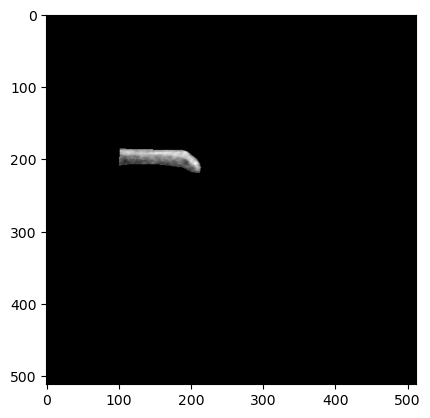

In [416]:
i=1
case=df_dataset.loc[i]['case']
file_name=df_dataset.loc[i]['file name']
label=df_dataset.loc[i]['standard mask']
mask=np.array(Image.open(file_path+str(case)+'/'+'mask/'+str(label).zfill(5)+'/3.png'))
image=np.array(Image.open(file_path+str(case)+'/'+'image/'+file_name).convert('L'))
image[np.where(mask!=255)]=0

plt.imshow(image,cmap='gray')

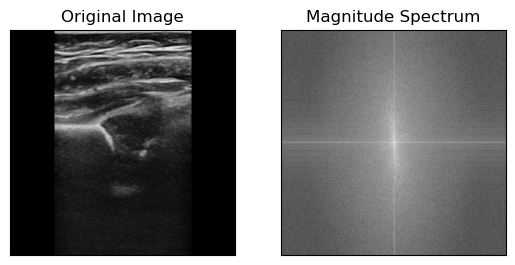

In [427]:
import cv2
import numpy as np
import matplotlib.pyplot as plt


image = np.array(Image.open(file_path+str(case)+'/'+file_name).convert('L'))


f_transform = np.fft.fft2(image)
f_transform_shifted = np.fft.fftshift(f_transform)


magnitude_spectrum = 20 * np.log(np.abs(f_transform_shifted))


plt.subplot(121), plt.imshow(image, cmap='gray')
plt.title('Original Image'), plt.xticks([]), plt.yticks([])

plt.subplot(122), plt.imshow(magnitude_spectrum, cmap='gray')
plt.title('Magnitude Spectrum'), plt.xticks([]), plt.yticks([])

plt.show()